In [ ]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to the CSV file in your Google Drive
csv_file_path = '/content/drive/MyDrive/sales_train.csv'

# Read CSV using pandas
data = pd.read_csv(csv_file_path)

# Display the CSV data
data


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D



from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [ ]:
# convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

<ipython-input-20-c80d85bc25f4>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['date'] = pd.to_datetime(data['date'])


In [ ]:
result = data[data['date'] == '2013-01-01']['item_cnt_day']
result.sum()

1951.0

In [ ]:
# select the date column as index
data.set_index(['date'],inplace=True)
# somme des item_cnt par jour
data = data['item_cnt_day'].resample('D').sum()
df=pd.DataFrame(data)

In [ ]:
data

date
2013-01-01    1951.0
2013-01-02    3817.0
2013-01-03    3846.0
2013-01-04    2574.0
2013-01-05    4863.0
               ...  
2015-12-06    2690.0
2015-12-07    2263.0
2015-12-08    1696.0
2015-12-09    3304.0
2015-12-10    1363.0
Freq: D, Name: item_cnt_day, Length: 1074, dtype: float64

In [ ]:
df

,item_cnt_day
date,
2013-01-01,1951.0
2013-01-02,3817.0
2013-01-03,3846.0
2013-01-04,2574.0
2013-01-05,4863.0
...,...
2015-12-06,2690.0
2015-12-07,2263.0
2015-12-08,1696.0


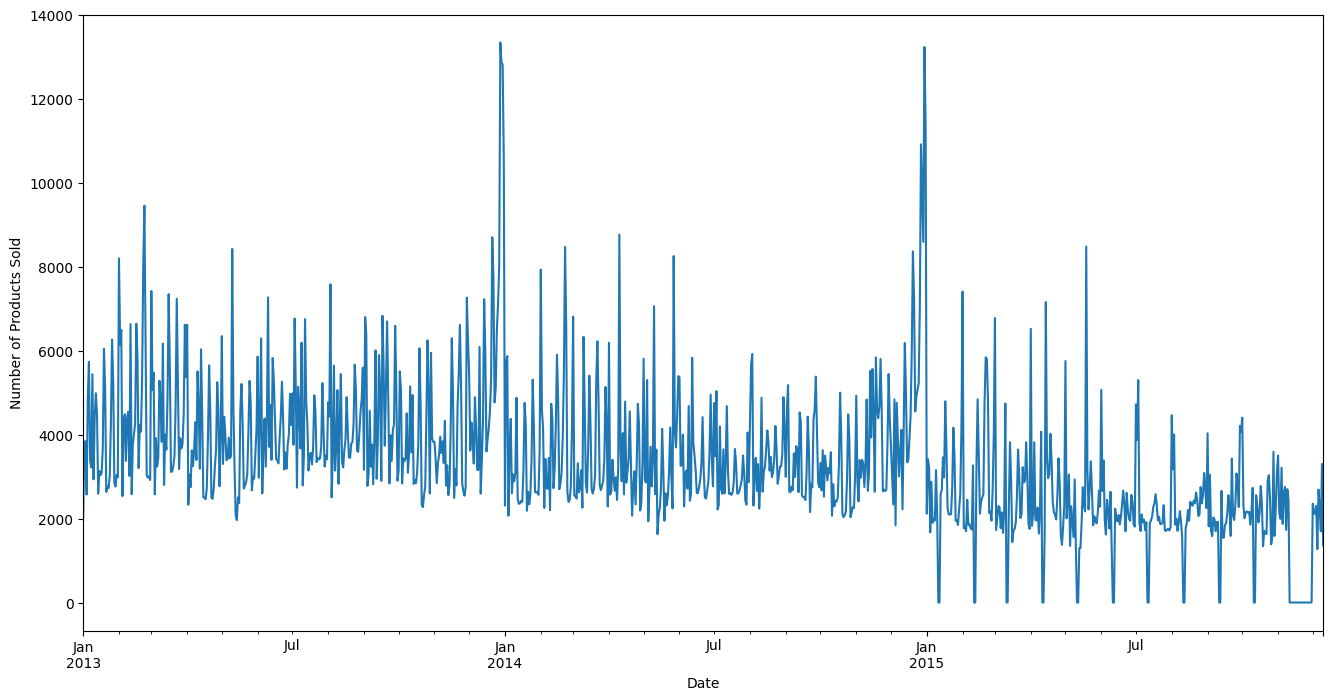

In [ ]:
# time series plot
plt.figure(figsize=(16,8))
df['item_cnt_day'].plot()
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.show()

In [ ]:
df_1=df.values
df_1=df_1.astype('float32')

scaler = MinMaxScaler(feature_range=(-1,1))
ts = scaler.fit_transform(df_1)

In [ ]:
ts

array([[-0.70756197],
       [-0.4278648 ],
       [-0.42351794],
       ...,
       [-0.7457843 ],
       [-0.5047591 ],
       [-0.7956981 ]], dtype=float32)

In [ ]:
timestep = 30

X= []
Y=[]

raw_data=ts

for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 850
Xtrain = X[:k,:,:]
Ytrain = Y[:k]

In [ ]:
Y

array([[-0.5524245 ],
       [ 0.22880912],
       [-0.07891774],
       ...,
       [-0.7457843 ],
       [-0.5047591 ],
       [-0.7956981 ]], dtype=float32)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(30, 1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(Xtrain, Ytrain, epochs=200, verbose=0)

In [ ]:
Xtest = X[k:,:,:]
Ytest= Y[k:]

In [ ]:
preds = model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)
Ytest=Ytest.reshape(-1,1)
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)
Ytrain=Ytrain.reshape(-1,1)
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)

7/7 [==============================] - 0s 16ms/step


1768804.0

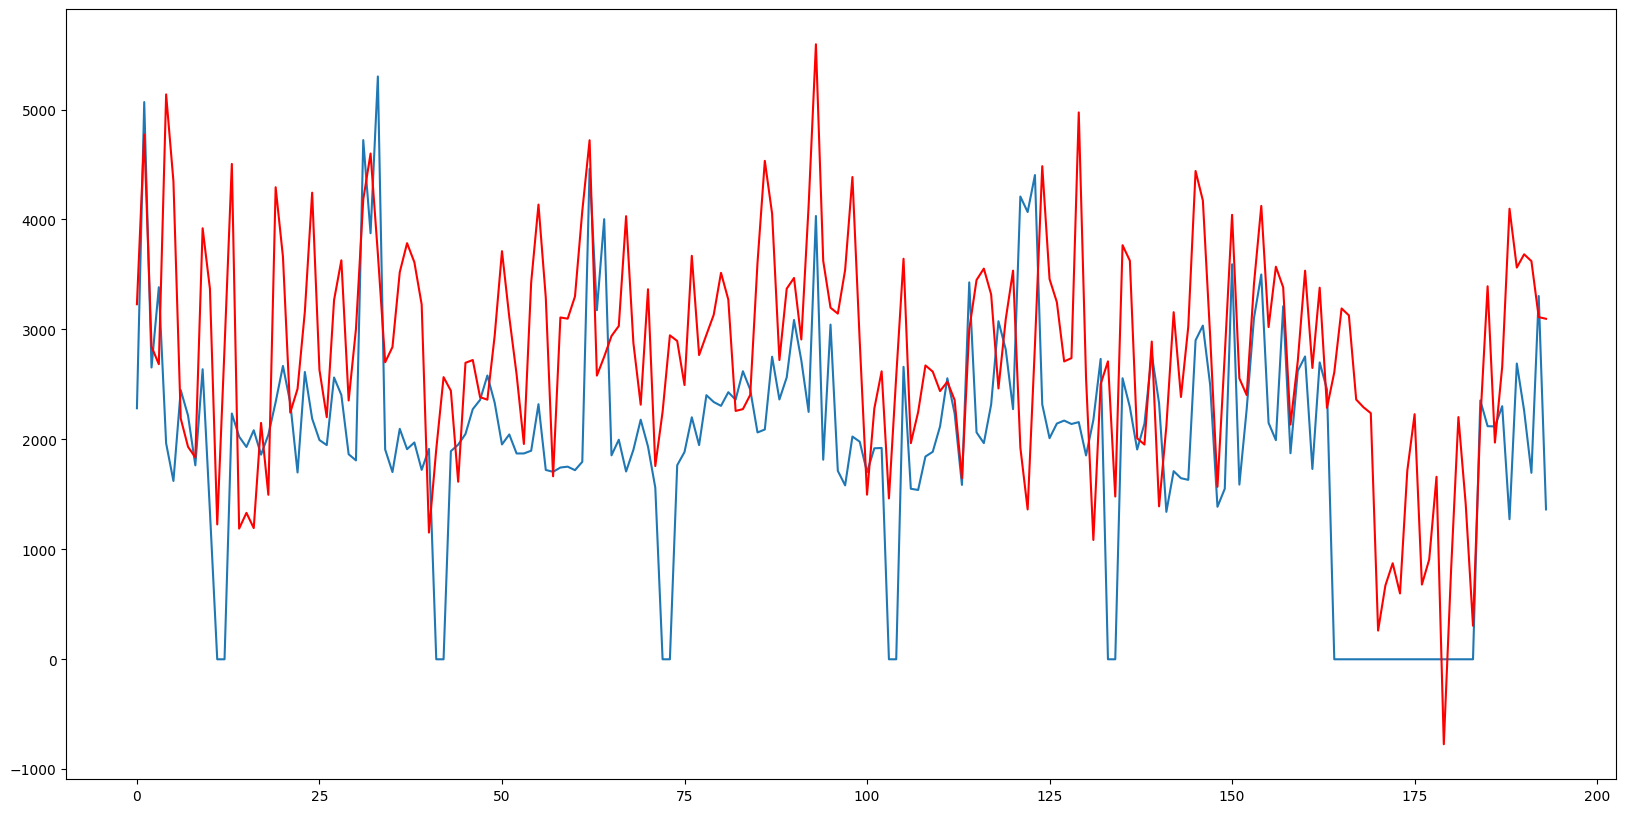

In [ ]:
# to see the prediction quality we plot the predicted serie and the original one
from matplotlib import pyplot
pyplot.figure(figsize=(20,10))
pyplot.plot(Ytest)
pyplot.plot(preds, 'r')
pyplot.show()